# **Computational Linear Algebra: Spectral Clustering Homework**

## Initialization:
Fill the missing values in this text box and in the following code-cell.

**Academic Year:** 2024/2025

### Team Members (Alphabetical Order):
1. Aljosevic, Ismail (337769);
2. Amato, Daniele (334211).

In [ ]:
StudentID1 = 337769
StudentID2 = 334211
random_seed = min([StudentID1, StudentID2])

## Importing modules

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import lil_array, csr_array, diags
from scipy.sparse.csgraph import connected_components
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
from scipy.linalg import solve


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#For using it on local machine, just put ""
project_base = "/content/drive/MyDrive/Computational Linear Algebra/Spectral Clustering Homework"

## **Loading data**

The data we will be working with includes:

 - **Circle.csv**- contains two columns representing the x and y coordinates of the points

 - **Spiral.csv** - contains three columns, where the third column indicates the true cluster index for each point

In [ ]:
def load_data(data_for_loading):
  data = {}
  for key, (path, columns) in data_for_loading.items():
    load_path = os.path.join(project_base, path)
    data[key] = pd.read_csv(load_path, header=None, names=columns)

  return data

In [ ]:
data_for_loading = {
    "Circle" : ("Circle.csv", ["X", "Y"]),
    "Spiral" : ("Spiral.csv", ["X", "Y", "Cluster"])
}

data = load_data(data_for_loading)

## **Plotting data**

In [ ]:
def plot_data(data_dict, fig_title = None):

  n = len(data_dict)
  fig, axes = plt.subplots(1, n, figsize=(8 * n, 7))  # all in one row

  if n == 1:
      axes = [axes]

  if fig_title:
    fig.suptitle(fig_title, fontsize=28, y=1.02)

  for ax, (title, data) in zip(axes, data_dict.items()):
    if "Cluster" in data.columns:
      scatter = ax.scatter(data["X"], data["Y"], c=data["Cluster"], cmap='viridis', alpha=0.7)

      clusters = np.array(data["Cluster"])
      unique_clusters = np.unique(clusters)
      handles = [
          Patch(color=scatter.cmap(scatter.norm(c)), label=f"Cluster {c}")
          for c in unique_clusters
      ]

      ax.legend(handles=handles, title="Clusters")
    else:
        ax.scatter(data["X"], data["Y"], alpha=0.7)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("X", fontsize=16)
    ax.set_ylabel("Y", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True)

  plt.tight_layout(rect=[0, 0, 1, 0.95])  # leaving space for subtitle
  if fig_title:
    plt.savefig(f"{fig_title}.png", format='png', bbox_inches='tight')
  else:
    plt.savefig("figure.png", format='png', bbox_inches='tight')

  plt.show()




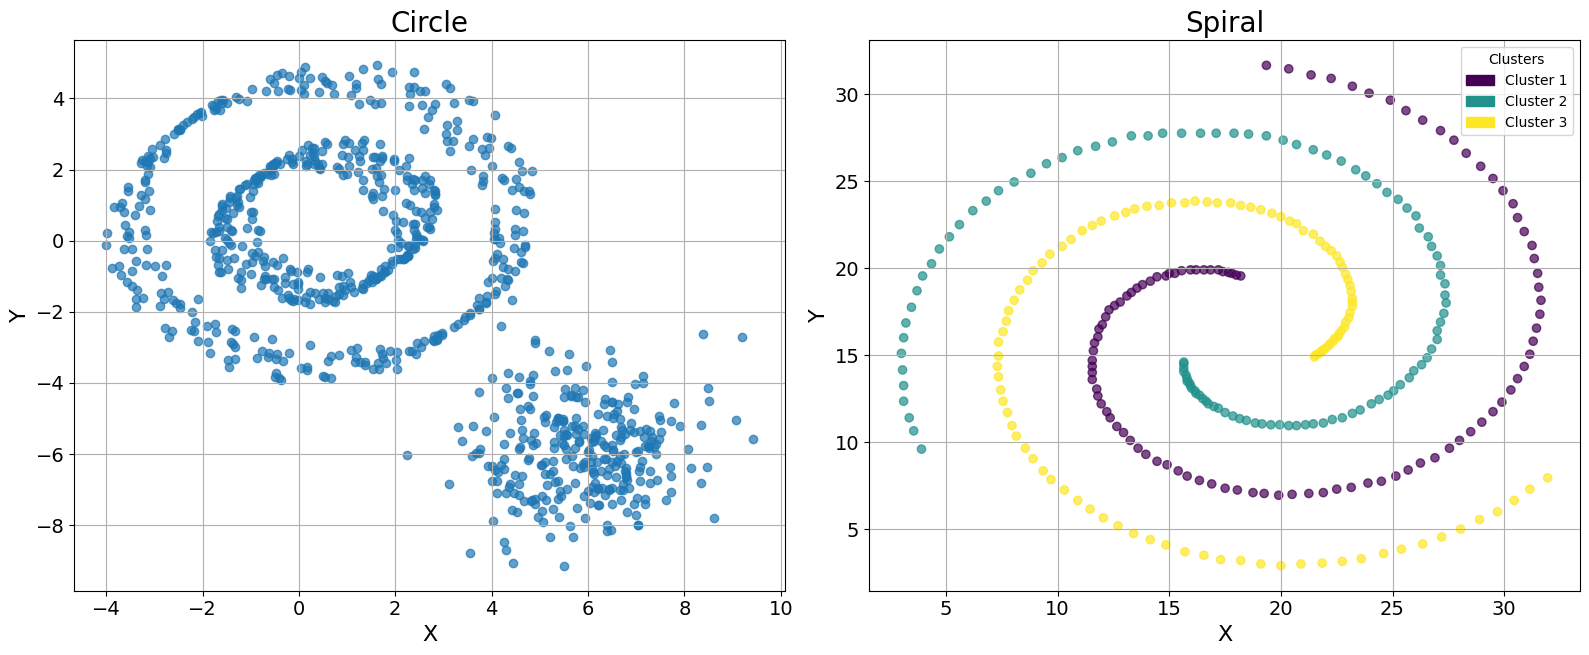

In [ ]:
plot_data(data)

### Dropping the `cluster` column from the Spiral dataset


In [ ]:
data["Spiral"].drop(columns="Cluster", inplace=True)

# **Exercises**

## 1.**Construction of k-Nearest Neighbor (k-NN) Similarity Graph and its Adjacency matrix *W***

We construct the k-NN similarity graph for values of *k* ∈ {10, 20, 40}, using a Gaussian kernel with σ = 1. The corresponding adjacency matrices *W* are computed, where the diagonal entries are set to zero by definition.

Steps for constructing similarity graph:

1. Define similarity matrix S where similarity scores between each pairs of points are stored.

2. From the similarity matrix S, construct a sparse adjacency matrix
 W by keeping, for each point, the weights (similarity values) to only its
k nearest neighbors.


In [ ]:
#1.
def create_similarity_matrix(X, sigma=1.0):
  dist_sq = euclidean_distances(X, X) ** 2
  S = np.exp(-dist_sq / (2 * sigma**2))
  np.fill_diagonal(S, 0)
  return S

In [ ]:
#1.

#Construction of S matrices
S_matrices = {name: create_similarity_matrix(X) for name, X in data.items()}

In [ ]:
#2.
def construct_knn_adjacency_matrix(S, k):

  n = S.shape[0]
  W = lil_array((n, n))

  for i in range(n):
    knn_indices = np.argsort(S[i])[::-1][:k]
    for j in knn_indices:
        W[i, j] = S[i, j]
        W[j, i] = S[i, j]

  return W.tocsr() #scipy format

In [ ]:
#2.

# Construction of Ws for each dataset and k
k_values = [10, 20, 40]
W_matrices = {}

for name, S in S_matrices.items():
  #for each dataset
  adjacency_by_k = {}

  #for each predefined k
  for k in k_values:
    adjacency_by_k[k] = construct_knn_adjacency_matrix(S, k)

  W_matrices[name] = adjacency_by_k


## 2. **Construction of the Degree Matrix *D* and the Laplacian Matrix *L***

1. For each similarity graph, we construct the corresponding degree matrix *D* from its adjacency matrix *W*:

$$
D_{ii} = \sum_{j} W_{ij}
$$

2. The unnormalized Laplacian matrix *L* is then computed using the standard definition:

$$
L = D - W
$$

3. We also perform the construction of the normalized symmetric Laplacian, which which was included as part of the optional exercises. The normalized symmetric Laplacian matrix is computed using the following definition:

$$
L_{\text{sym}} = D^{-1/2} L D^{-1/2} = I - D^{-1/2} W D^{-1/2}
$$


### **Constructing Degree matrices**

In [ ]:
#1.
def construct_degree_matrix(W):

  n = W.shape[0]
  D = lil_array((n, n))

  for i in range(n):
      degree = W[i, :].sum()
      D[i, i] = degree

  return D.tocsr()

In [ ]:
#1.

#Construction of degree matrices for each dataset and k
k_values = [10, 20, 40]
D_matrices = {}

for name, W_k_dict in W_matrices.items():
  #for each dataset
  diagonals_by_k = {}
  for k in k_values:
    W = W_k_dict[k] #getting adjacency matrix for defined k
    diagonals_by_k[k] = construct_degree_matrix(W)

  D_matrices[name] = diagonals_by_k

### **Constructing Lapalacian matrices**

In [ ]:
#2.
def construct_laplacian_matrix(W, D, type_="unnormalized"):
  L = D - W
  if type_ == "unnormalized":
    return L
  elif type_ == "symmetric":
    degrees = D.diagonal()
    D_inv_sqrt = diags(1.0 / degrees**0.5) #diags construct sparse matrix from diagonals
    L_sym = D_inv_sqrt @ L @ D_inv_sqrt
    return L_sym

In [ ]:
#2.

#Construction of Lapalcian matrices for each dataset and k

k_values = [10, 20, 40]
names = W_matrices.keys()

L_matrices = {}

for name in names:
  #for each dataset
  laplacians_by_k = {}
  for k in k_values:
    W = W_matrices[name][k] #getting adjacency matrix for defined k
    D = D_matrices[name][k]

    laplacians_by_k[k] = construct_laplacian_matrix(W, D)

  L_matrices[name] = laplacians_by_k

In [ ]:
#3.

#Construction of normalized symmetric Lapalcian matrices for each dataset and k

k_values = [10, 20, 40]
names = W_matrices.keys()

L_symmetric_matrices = {}

for name in names:
  #for each dataset
  laplacians_by_k = {}
  for k in k_values:
    W = W_matrices[name][k] #getting adjacency matrix for defined k
    D = D_matrices[name][k]

    laplacians_by_k[k] = construct_laplacian_matrix(W, D, type_="symmetric")

  L_symmetric_matrices[name] = laplacians_by_k

## 3. Determining the Number of Connected Components in the Similarity Graph

1. To determine the number of connected components in the similarity graph, we compute the number of eigenvalues equal to zero in the Laplacian matrix, as this number corresponds to the number of connected components.

2. To get better understanding of the structural properties and sparsity patterns of the matrices, we visualize the Laplasian matrices using **spy plots**.





### **Connected components**

In [ ]:
def num_of_connected_components(L, M = 5):
  eigenvalues, _ = eigsh(L, M, which="SM")
  eps = 1e-9
  num_components = np.sum(eigenvalues < eps) # this is comparison with 0 eigenvalues == 0, precision of computation is lost
  return num_components

In [ ]:
#1.

num_connected_components = {}
names = L_matrices.keys()

for name in names:
  #for each dataset
  num_connected_components_by_k = {}

  print(f"**** {name} DATASET ****")
  for k in k_values:
    L = L_matrices[name][k]
    num_connected_components_by_k[k] = num_of_connected_components(L)
    print(f"For k = {k}, number of connected components is: {num_connected_components_by_k[k]}")


  num_connected_components[name] = num_connected_components_by_k
  print()


**** Circle DATASET ****
For k = 10, number of connected components is: 2
For k = 20, number of connected components is: 1
For k = 40, number of connected components is: 1

**** Spiral DATASET ****
For k = 10, number of connected components is: 1
For k = 20, number of connected components is: 1
For k = 40, number of connected components is: 1



### **Spy graphs**

In [ ]:
#2.

def plot_spy_graphs(L_dict, name):
  cols = len(L_dict)
  fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 4))

  if cols == 1:
      axes = [axes]  # ensure it's iterable

  for i, (k, L) in enumerate(L_dict.items()):
      axes[i].spy(L, markersize=1)
      axes[i].set_title(f"Spy Graph, k={k}")
      axes[i].set_xlabel("Columns")
      axes[i].set_ylabel("Rows")

  fig.suptitle(f"Sparsity Pattern — {name}", fontsize=16, y=1.05)
  plt.tight_layout()
  plt.savefig(f"{name}_spyplots.png", format='png')
  plt.show()




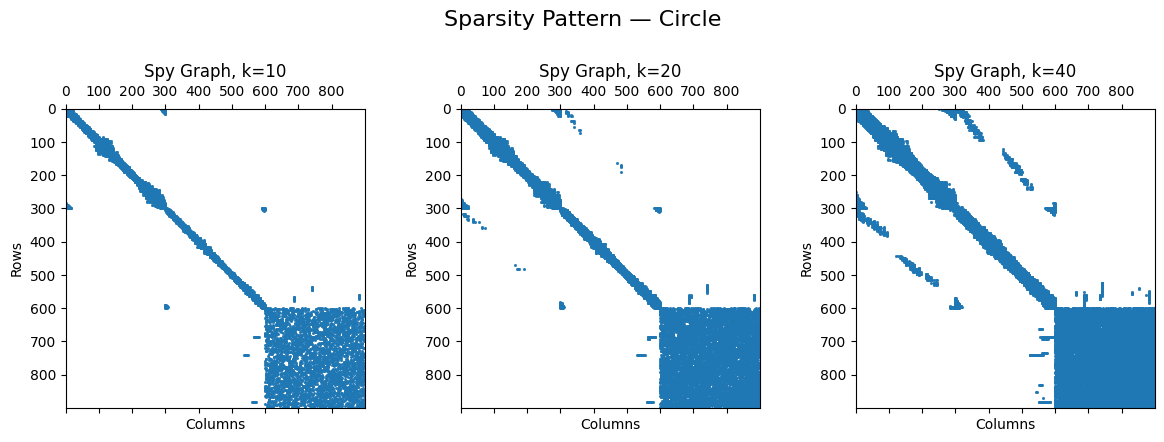

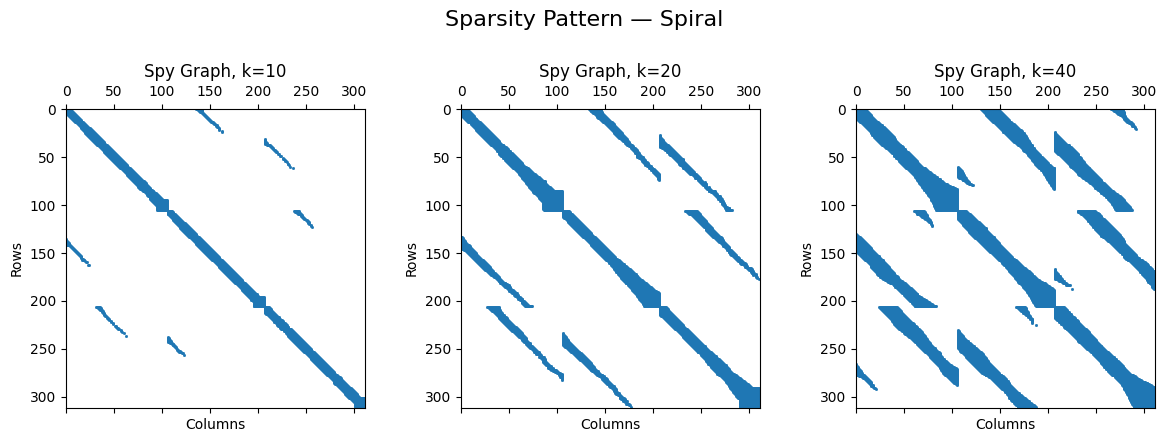

In [ ]:
#2.
for name, L_dict in L_matrices.items():
  plot_spy_graphs(L_dict, name)

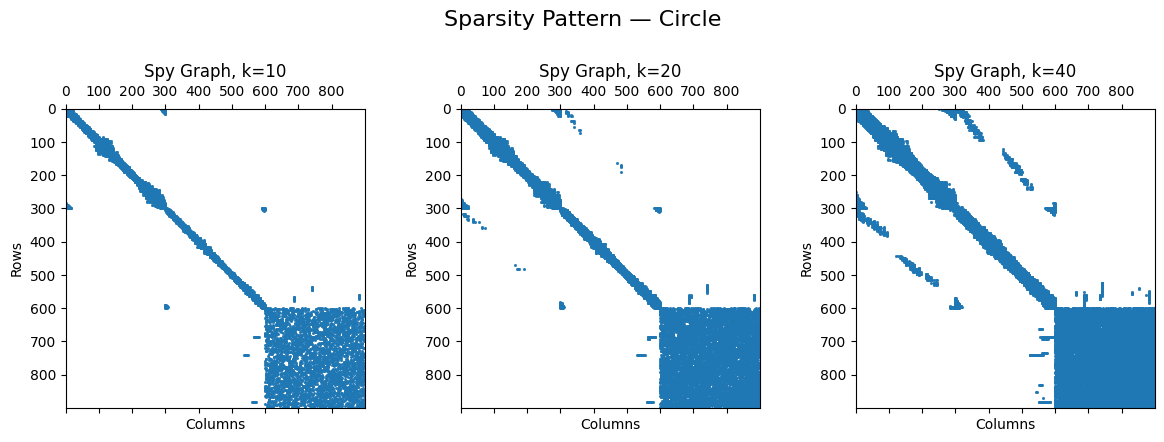

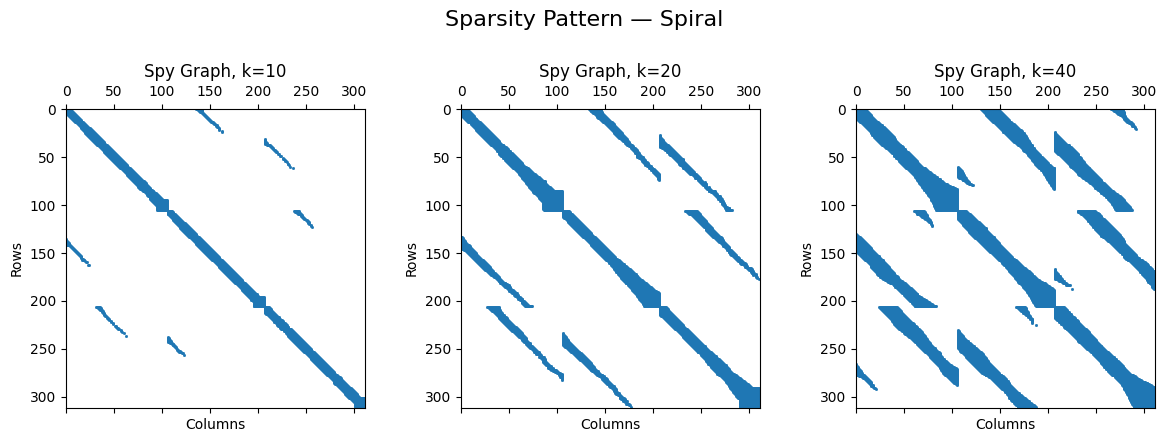

In [ ]:
#2. Normalized Symmetric Laplacians
for name, L_dict in L_symmetric_matrices.items():
  plot_spy_graphs(L_dict, name)

## **Observations**

For the **Circle** dataset, we obtained the following number of connected components:

- **k = 10** : 2 connected components  
- **k = 20** : 1 connected component  
- **k = 40** : 1 connected component  

This illustrates how increasing k leads to a more connected graph structure.

By considering the spy plots for circle data, we can spot strong square in the bottom right corner, indicating that one group of nodes are very well conected, thus represents separate cluster. As k increases, we can see that more elements outside of diagonal appear, as expected. This suggests, that nodes are statrting to connect with farther nodes, and in that way it decreases cluster accuracy.

---

For the **spiral** dataset, we obtained the following number of connected components:

- **k = 10**: 1 connected component
- **k = 20**: 1 connected component  
- **k = 40**: 1 connected component  

This indicates that even at lower values of k, the graph remains fully connected, suggesting a high level of overall connectivity in the data structure.

By considering the spy plots for spiral data, we can spot the block structure
along the diagonal. This suggests the presence of distinct clusters, even though results for connected components implify that data are fully connected.
As k increases, we see that more elements outside of diagonal appear, same as circle data.

---

The spy plots for the symmetric normalized Laplacians and the unnormalized Laplacians are identical, which suggests that the degrees of the nodes are relatively uniform across the graph.




## 4. **Analysis of the Smallest Eigenvalues of the Laplacian Matrix**

We compute the smallest eigenvalues-eigenvectors pairs of the Laplacian matrix and use eigevalues to determine a number of clusters.

1. For computing the smallest eigenvalue-eigenvector pairs, we use our implementation of the **Inverse Power Method** in combination with the **Householder transformation (Deflation)** technique.

2. To determine a suitable number of clusters, we applied the eigengap heuristic, which identifies the largest proportional increase between consecutive eigenvalues in the spectrum.



### **Deflation, Inverse Power Method, and Computation of m smallest eigenvalues**


In [ ]:
#1
def householder_deflation(L, x):

  n = L.shape[0]
  e = np.zeros_like(x)
  e[0] = 1

  #construct householder vector
  x_modul = np.linalg.norm(x)
  u = x + np.sign(x[0]) * x_modul * e #we write np.sign(x[0]) because of numerical stability
  v = u / np.linalg.norm(u)

  H = np.eye(n) - 2 * np.outer(v, v)
  L_tilde = H @ L @ H

  L_2 = L_tilde[1:,1:]

  return L_2, H

#1
def inverse_power_method(L, p, max_iterations=1000, threshold=1e-12):

  n = L.shape[0]
  y = np.ones(n)
  y = y / np.linalg.norm(y)

  lambda_old = 0.0

  for i in range(max_iterations):
    z = solve(L - p * np.eye(n), y)
    y_new = z / np.linalg.norm(z)
    lambda_new = np.dot(y_new.T, L @ y_new) / np.dot(y_new, y_new)

    if abs(lambda_new - lambda_old) < threshold:
        break

    y = y_new
    lambda_old = lambda_new

  return y_new, lambda_new

#1
def find_M_smallest_eigenvalues(L, M=5):

  eigenvectors = []
  eigenvalues = []
  householder_matrices = []

  alpha = 1e-7
  p = 1e-4

  for i in range(M):
    eigenvector, eigenvalue = inverse_power_method(L, p)

    L, H = householder_deflation(L, eigenvector)
    householder_matrices.append(H)

    #transform eigenvector to full size because deflation reduces the size
    if i > 0:
      for j in reversed(range(i)):
        H_j = householder_matrices[j]
        eigenvector = np.pad(eigenvector, (1, 0))
        eigenvector = H_j @ eigenvector


    eigenvectors.append(eigenvector)
    eigenvalues.append(eigenvalue)

    p = eigenvalue + alpha

  #sorting them
  idx = np.argsort(eigenvalues)
  eigenvalues = [eigenvalues[i] for i in idx]
  eigenvectors = [eigenvectors[i] for i in idx]

  return eigenvalues, eigenvectors

In [ ]:
#1
#Computation of smallest eigenvalues (eigenvectors) for each k

eigenpairs = {}
names = L_matrices.keys()

for name in names:
  eigenpairs_by_k = {}

  for k in k_values:
    eigvals, eigvecs = find_M_smallest_eigenvalues(L_matrices[name][k])
    eigenpairs_by_k[k] = (eigvals, eigvecs)

  eigenpairs[name] = eigenpairs_by_k

In [ ]:
#1
#Computation of smallest eigenvalues (eigenvectors) for each k for L symmetric

eigenpairs_symmetric = {}
names = L_symmetric_matrices.keys()

for name in names:
  eigenpairs_by_k_symmetric = {}

  for k in k_values:
    eigvals, eigvecs = find_M_smallest_eigenvalues(L_symmetric_matrices[name][k])
    eigenpairs_by_k_symmetric[k] = (eigvals, eigvecs)

  eigenpairs_symmetric[name] = eigenpairs_by_k_symmetric

### **Plotting the Smallest Eigenvalues and Estimating the Number of Clusters**


In [ ]:
#2
def plot_eigenvalues(eigenvalues_dict, name, M=5):

  cols = len(eigenvalues_dict)
  fig, axes = plt.subplots(1, cols, figsize=(2 * (M + 1), 4))

  for i, (k, eigvals) in enumerate(eigenvalues_dict.items()):
    axes[i].plot(range(1, M + 1), eigvals[0], 'b*')
    axes[i].set_title(f"Eigenvalues, k={k}")
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel("λ")
    axes[i].grid(True)

  fig.suptitle(f"Eigenvalue Spectrum — {name}", fontsize=16, y=1.05)

  plt.tight_layout()

  plt.savefig(f"{name}_eigenvalues.png", format='png')

  plt.show()

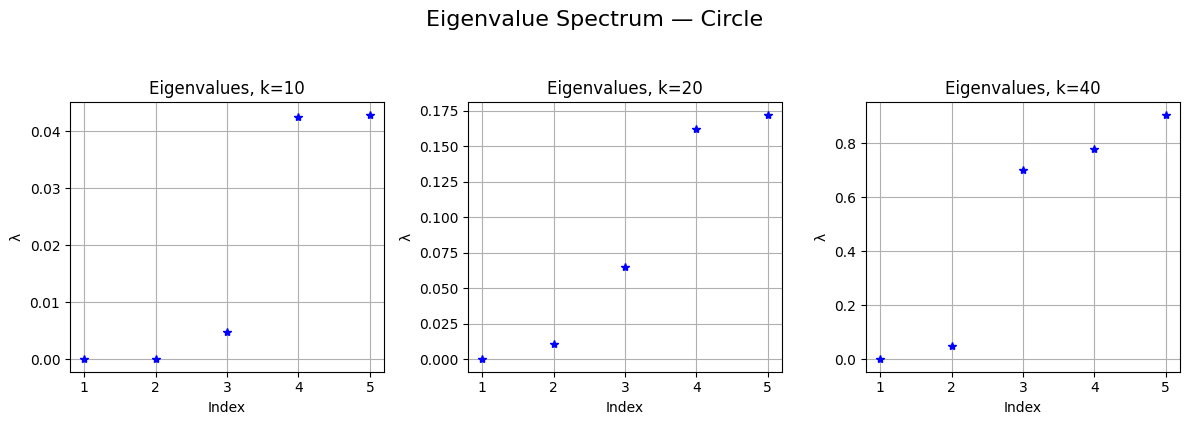

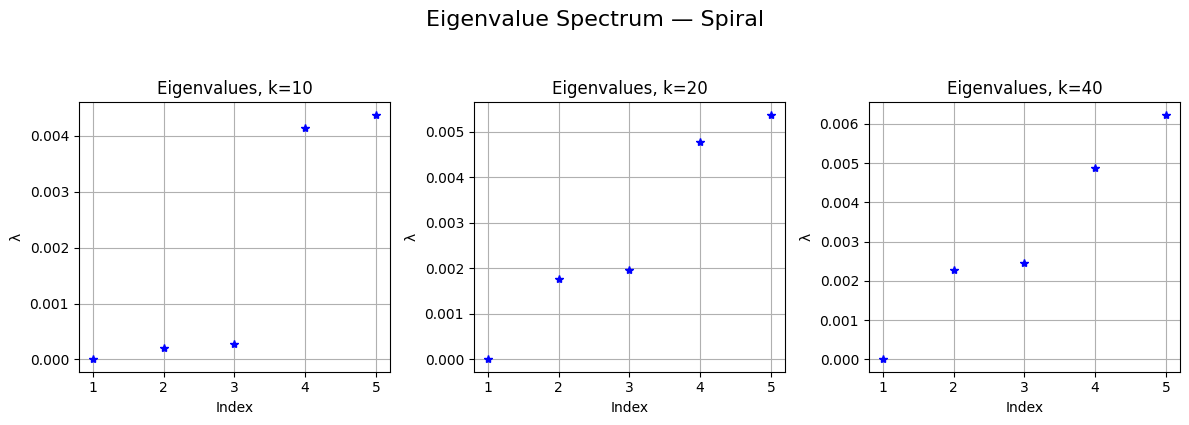

In [ ]:
#2
#Plotting for based on unnormalized Laplacians
for name, eigpair in eigenpairs.items():
  plot_eigenvalues(eigpair, name)

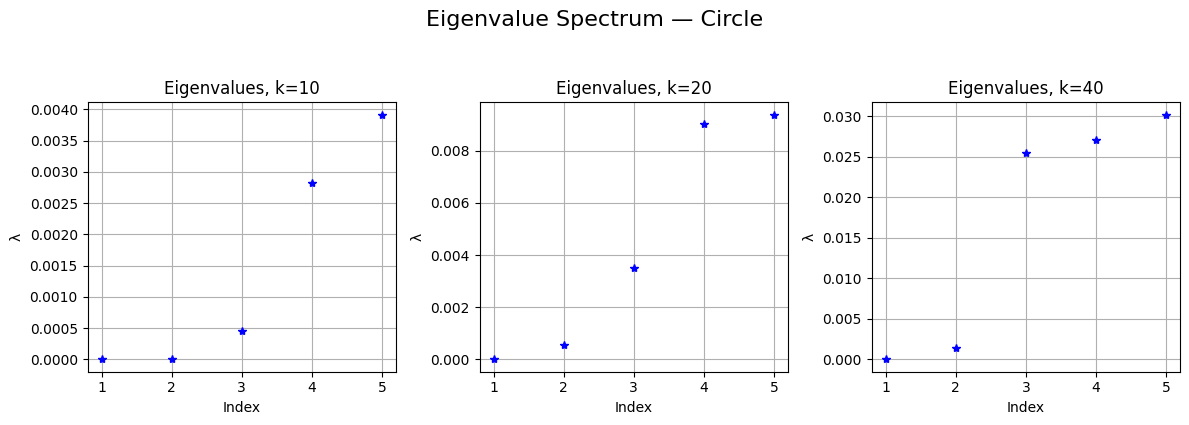

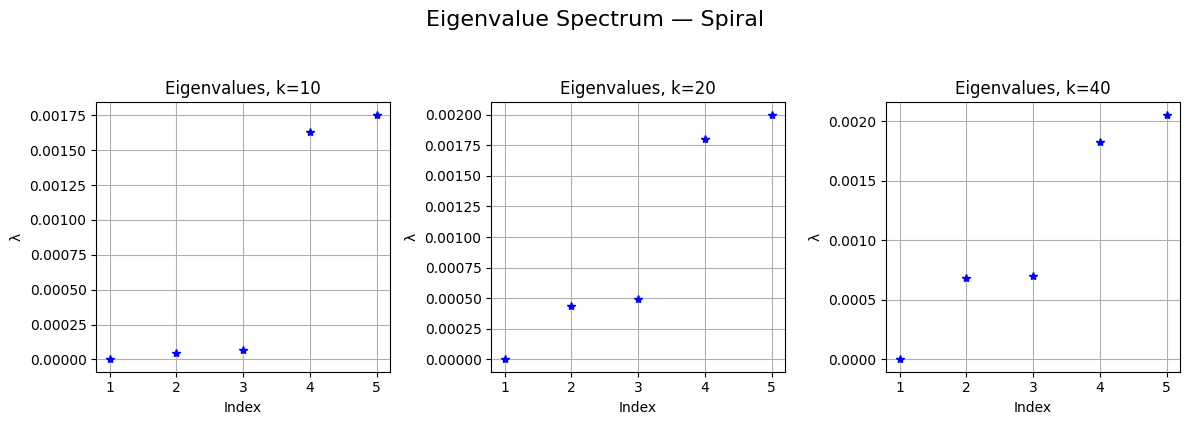

In [ ]:
#2
#Plotting for based on symmetric normalized Laplacians
for name, eigpair in eigenpairs_symmetric.items():
  plot_eigenvalues(eigpair, name)

## **Observations**

### Results for the **Circle** Dataset

**1. k = 10**  
- A noticeable eigengap is observed between the **3rd** and **4th** eigenvalues, suggesting the presence of **three clusters**.  
- **Chosen number of clusters:** M = 3

**2. k = 20**  
- The first noticeable eigengap appears between the **2nd** and **3rd** eigenvalues, suggesting **two main clusters**.  
- However, the gap between the **3rd** and **4th** eigenvalues is even larger.  
- Considering both the relative jumps and the magnitudes of the eigenvalues, selecting **three clusters** may be more appropriate.  
- **Chosen number of clusters:** M = 3

**3. k = 40**  
- A significant eigengap is observed between the **2nd** and **3rd** eigenvalues, suggesting the presence of **two clusters**.  
- **Chosen number of clusters:** M = 2

---

### Results for the **Spiral** Dataset

**1. k = 10**  
- A clear eigengap appears between the **3rd** and **4th** eigenvalues, suggesting the presence of **three clusters**.  
- **Chosen number of clusters:** M = 3

**2. k = 20**  
- The **2nd** and **3rd** eigenvalues are nearly equal, followed by a noticeable gap after the **3rd**, suggesting **three clusters**.  
- **Chosen number of clusters:** M = 3

**3. k = 40**  
- A similar pattern to the one observed for *k = 20* is present, with a gap after the **3rd** eigenvalue, again suggesting the presence of **three clusters**.  
- **Chosen number of clusters:** M = 3


Both the **symmetric normalized Laplacian** and the **unnormalized Laplacian** produced similar results in terms of interpretability and clustering structure.

The key difference lies in the **scale of the eigenvalues**—the eigenvalues of the symmetric normalized Laplacian are generally smaller, as expected due to the normalization process.

This indicates that, in this case, the choice between normalized and unnormalized Laplacians does not significantly affect the clustering outcome.


In [ ]:
number_of_clusters = {

    "Circle": {
        10: 3,
        20: 3,
        40: 2
    },
    "Spiral": {
        10: 3,
        20: 3,
        40: 3
    }

}


### 5. **Computation of Eigenvectors for Spectral Clustering**

In the previous exercise, we computed and stored the first  m = 5 eigenpairs (eigenvalues and corresponding eigenvectors) for each Laplacian matrix.

1. To avoid redundant computation, we now simply extract the required number of eigenvectors from the previously saved results for each dataset and value of k.

2. After selecting the M smallest eigenvectors, we form the matrix $U$ which represents a spectral embedding of the original data.



In [ ]:
#Extracting eigenvectors and computing matrix U

U_matrices = {}
names = L_matrices.keys()

for name in names:
  U_matrices_by_k = {}

  for k in k_values:
    num_of_cluster = number_of_clusters[name][k]
    U_matrices_by_k[k] = np.array(eigenpairs[name][k][1][:num_of_cluster]).T

  U_matrices[name] = U_matrices_by_k

In [ ]:
#Extracting eigenvectors and computing matrix U for symmetric normalized laplacian

U_symmetric_matrices = {}
names = L_symmetric_matrices.keys()

for name in names:
  U_symmetric_matrices_by_k = {}

  for k in k_values:
    num_of_cluster = number_of_clusters[name][k]
    U_symmetric_matrices_by_k[k] = np.array(eigenpairs_symmetric[name][k][1][:num_of_cluster]).T

  U_symmetric_matrices[name] = U_symmetric_matrices_by_k

### **6. Clustering the Spectral Embedding Using the K-Means Algorithm**


In [ ]:
#K-means on U matrices
cluster_labels = {}
names = U_matrices.keys()

for name in names:

  cluster_labels_by_k = {}

  for k in k_values:
    kmeans = KMeans(n_clusters=number_of_clusters[name][k], random_state=random_seed)
    labels = kmeans.fit_predict(U_matrices[name][k])
    cluster_labels_by_k[k] = labels

  cluster_labels[name] = cluster_labels_by_k

In [ ]:
#K-means on U matrices from symmetric Laplacians
cluster_labels_symmetric = {}
names = U_symmetric_matrices.keys()

for name in names:

  cluster_symmetric_labels_by_k = {}

  for k in k_values:
    kmeans = KMeans(n_clusters=number_of_clusters[name][k], random_state=random_seed)
    labels = kmeans.fit_predict(U_symmetric_matrices[name][k])
    cluster_symmetric_labels_by_k[k] = labels

  cluster_labels_symmetric[name] = cluster_symmetric_labels_by_k

### **7. Assigning Original Data Points to Spectral Clusters**


In [ ]:
clustered_data = {}
names = U_matrices.keys()

for name in names:
  clustered_data_by_k = {}
  for k in k_values:

    temp_data = data[name].copy()
    temp_data["Cluster"] = cluster_labels[name][k]
    clustered_data_by_k[k] = temp_data

  clustered_data[name] = clustered_data_by_k

In [ ]:
clustered_data_symmetric = {}
names = U_symmetric_matrices.keys()

for name in names:
  clustered_symmetric_data_by_k = {}
  for k in k_values:

    temp_data = data[name].copy()
    temp_data["Cluster"] = cluster_labels_symmetric[name][k]
    clustered_symmetric_data_by_k[k] = temp_data

  clustered_data_symmetric[name] = clustered_symmetric_data_by_k

## **8. Plotting Clusters in the Original Data Space**


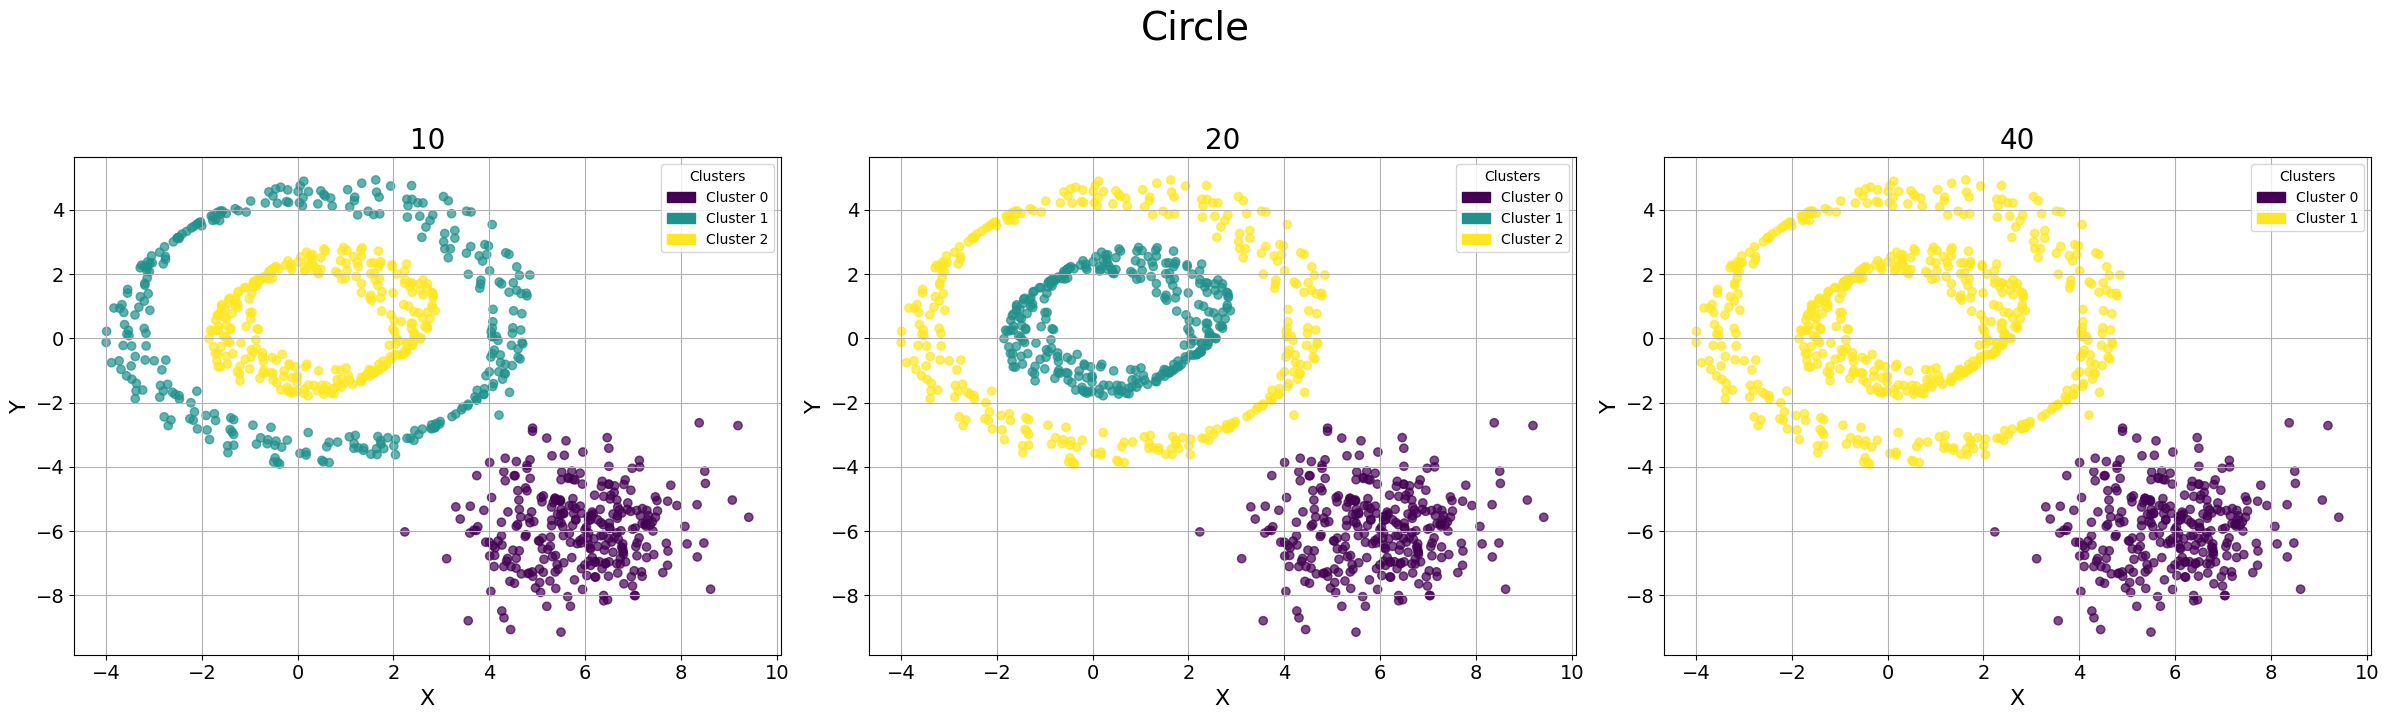

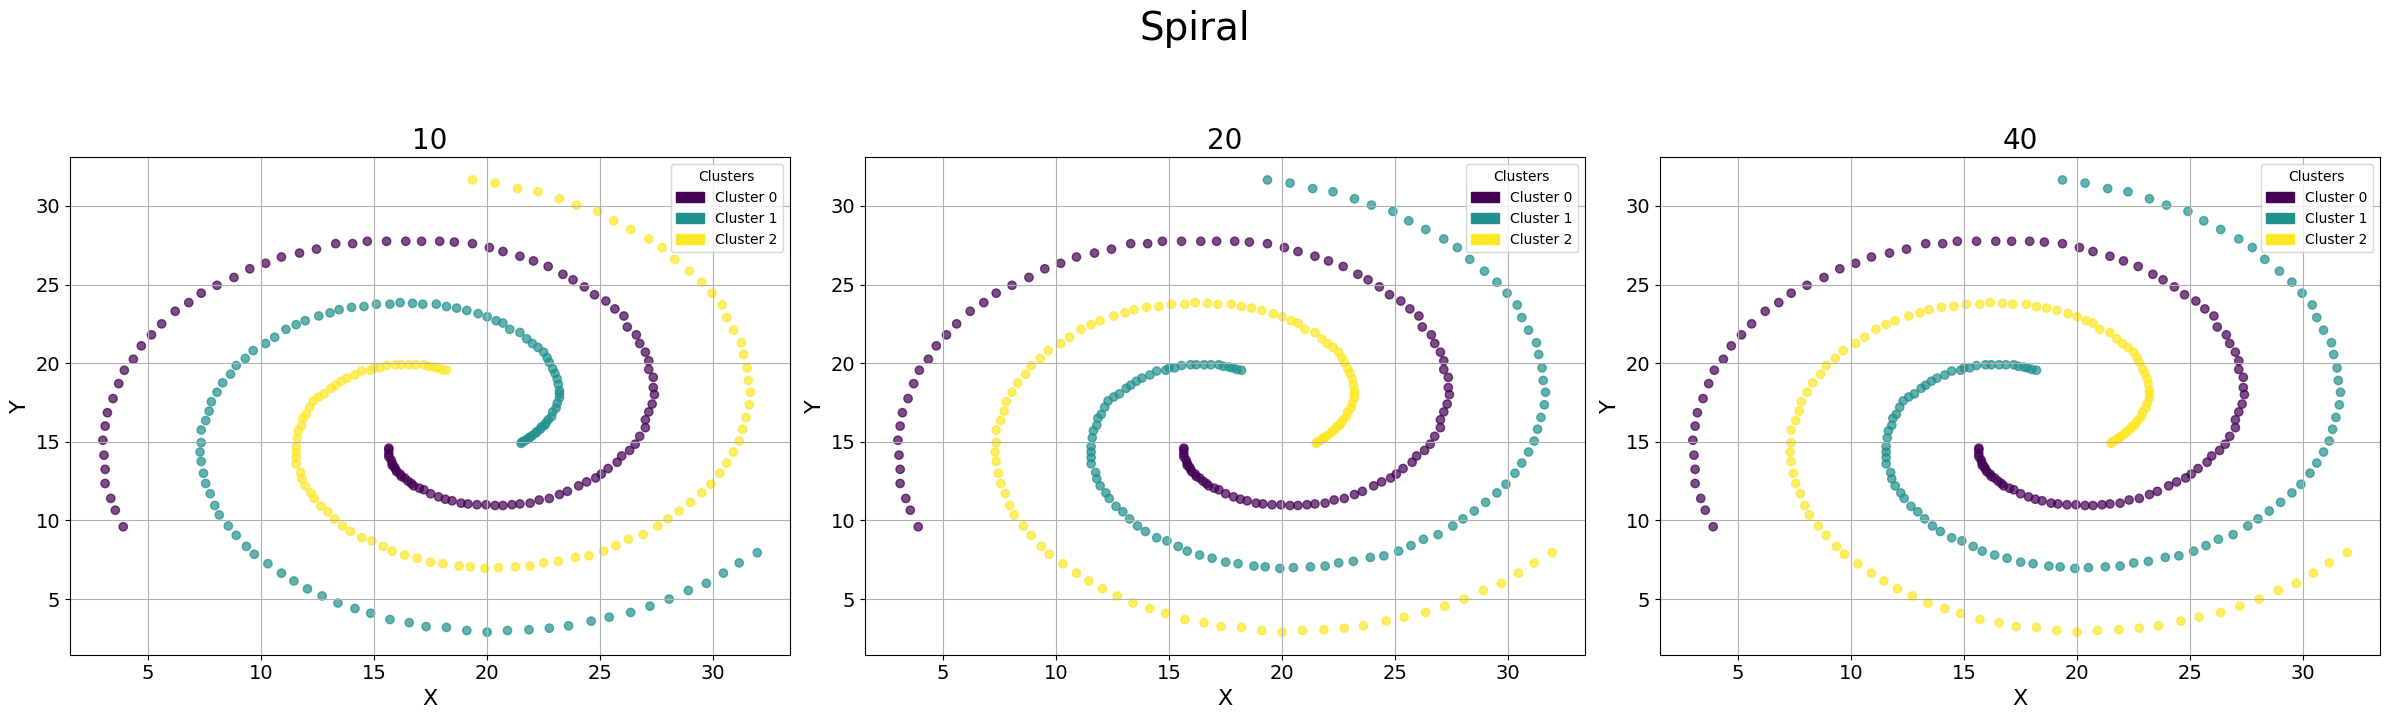

In [ ]:
for name, clustered_data_by_k in clustered_data.items():
  plot_data(clustered_data_by_k, name)

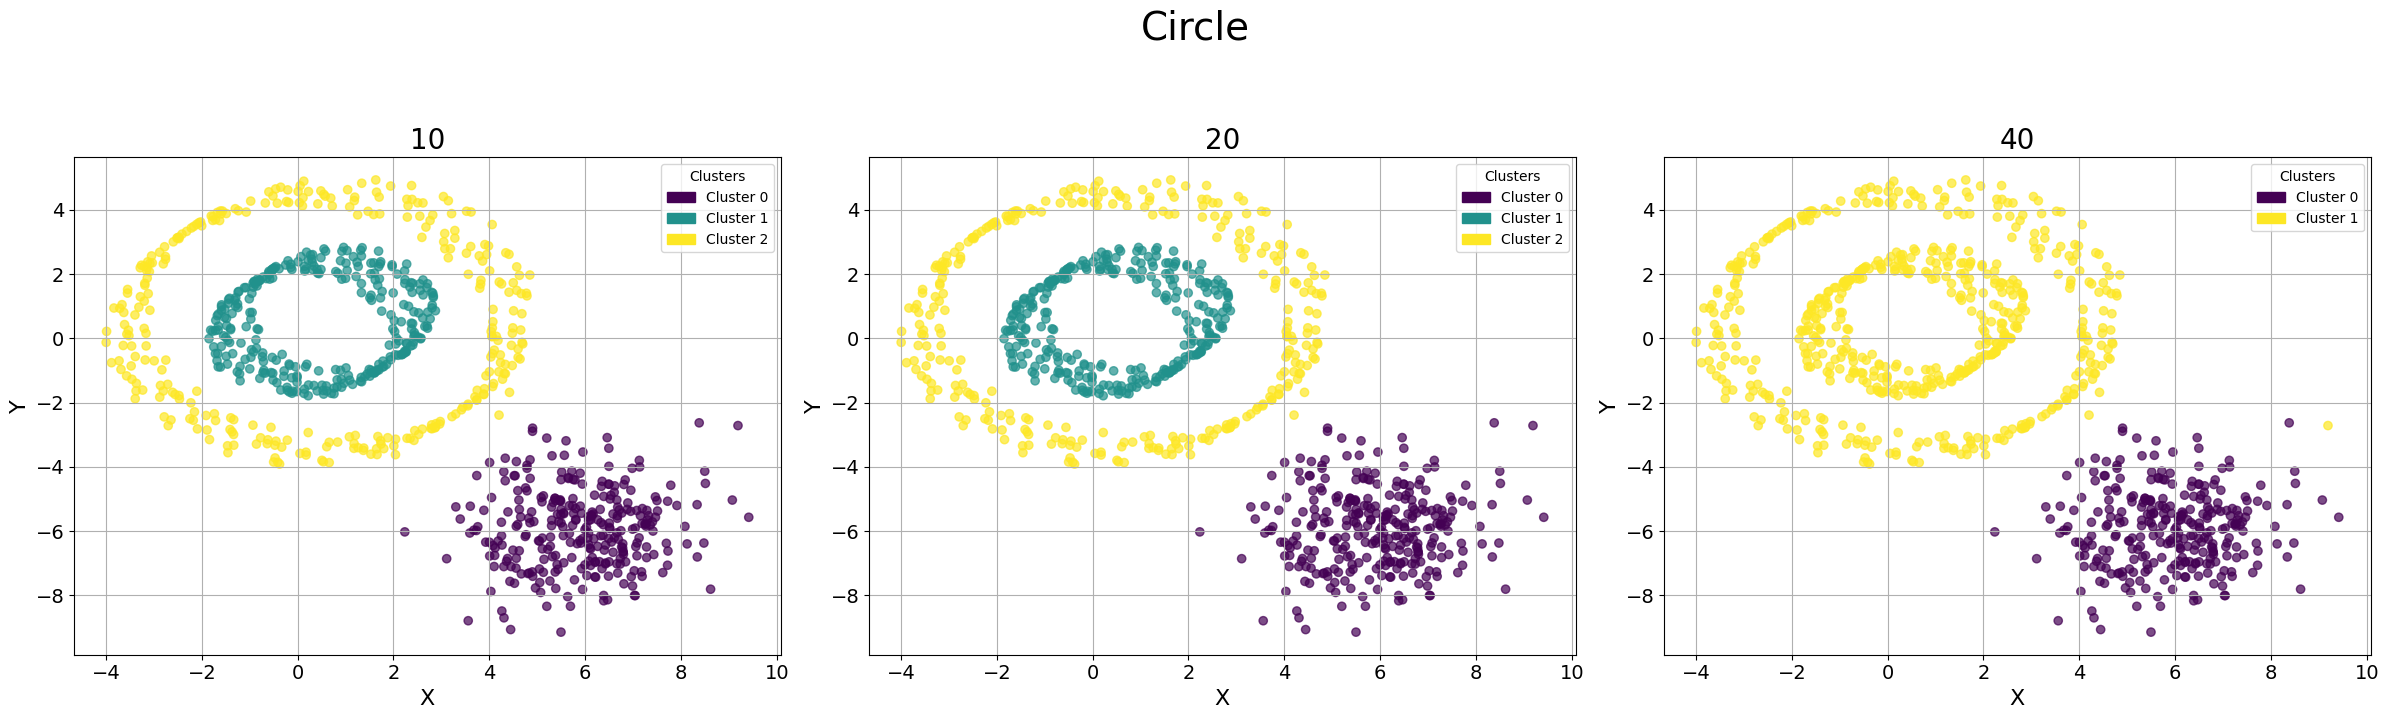

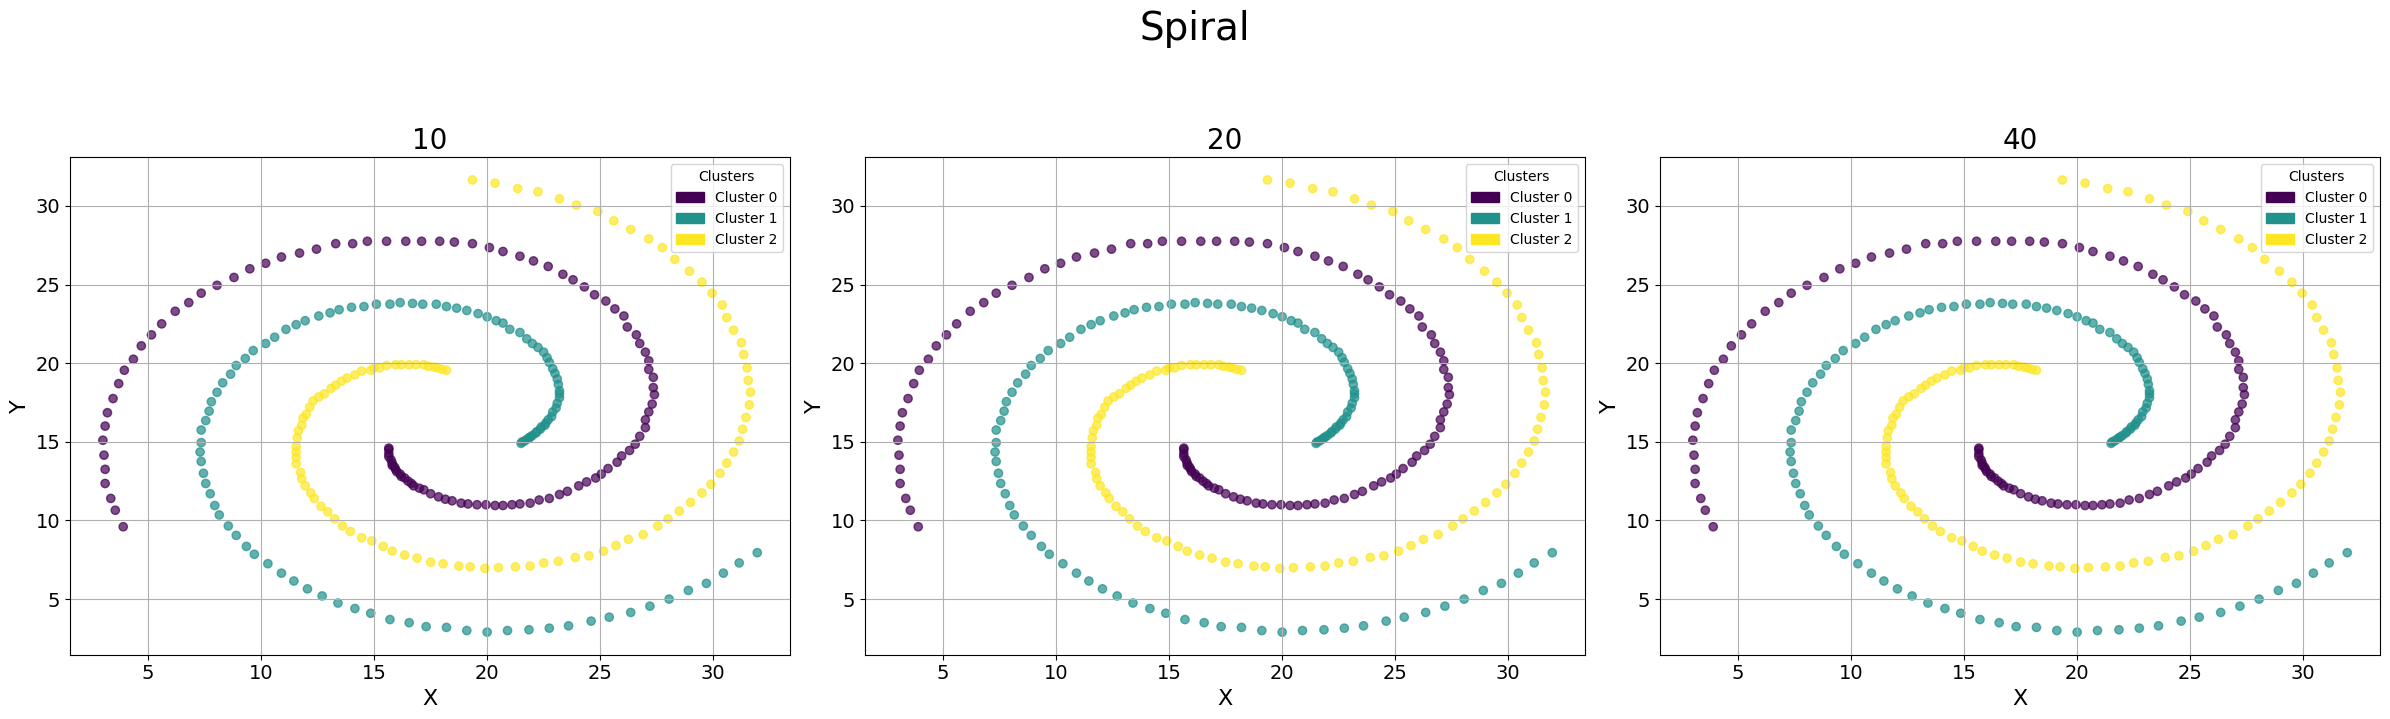

In [ ]:
#Plotting for symmetric data
for name, clustered_data_by_k in clustered_data_symmetric.items():
  plot_data(clustered_data_by_k, name)

### **Observations**

#### **Results for the Circle Dataset**

- **3 clusters** for *k = 10* and *k = 20*  
- **2 clusters** for *k = 40*

The cluster colored in **purple** corresponds to the square structure observed in the bottom right corner of the spy plot.

For *k = 20* and *k = 40*, we can clearly observe that circle-shaped clusters tend to merge due to increased connectivity between further neighbors.

**Overall, the clustering result for *k = 10* provides the best and most interpretable separation.**

Regarding the results obtained using the **symmetric normalized Laplacian**, the clustering outcomes are **identical**, as expected.

The only noticeable difference appears for *k = 40*, where one point from the **purple cluster** is clearly misclassified and assigned to the **yellow cluster**.

---

#### **Results for the Spiral Dataset**

- **3 clusters** for all values of *k*

This consistency suggests that the spiral structure naturally supports a **three-cluster interpretation**, regardless of the sparsity level *k* in the similarity graph.

Results obtained using the **symmetric normalized Laplacian** are **completely identical** to those obtained with the unnormalized Laplacian, as expected.

**Overall, the clustering result for *k = 10* is the most reliable**, as it is based on a smaller number of nearest neighbors.


## **9. Comparison with Other Clustering Methods**

To evaluate the effectiveness of spectral clustering, we compute the clusters for the same set of points using standard clustering algorithms such as **K-means**, for M = 2 and M = 3 which represent number of clusters.

### **Assigning Original Data Points to K-means clusters**

In [ ]:
clustered_data_k_means = {}
names = data.keys()
for name in names:
    clustered_data_k_means_by_m = {}

    for m in [2, 3]:
        kmeans = KMeans(n_clusters=m, random_state=random_seed)
        labels = kmeans.fit_predict(data[name])

        temp_data = data[name].copy()
        temp_data["Cluster"] = labels

        clustered_data_k_means_by_m[m] = temp_data

    clustered_data_k_means[name] = clustered_data_k_means_by_m


### **Plotting Clusters in the Original Data Space**

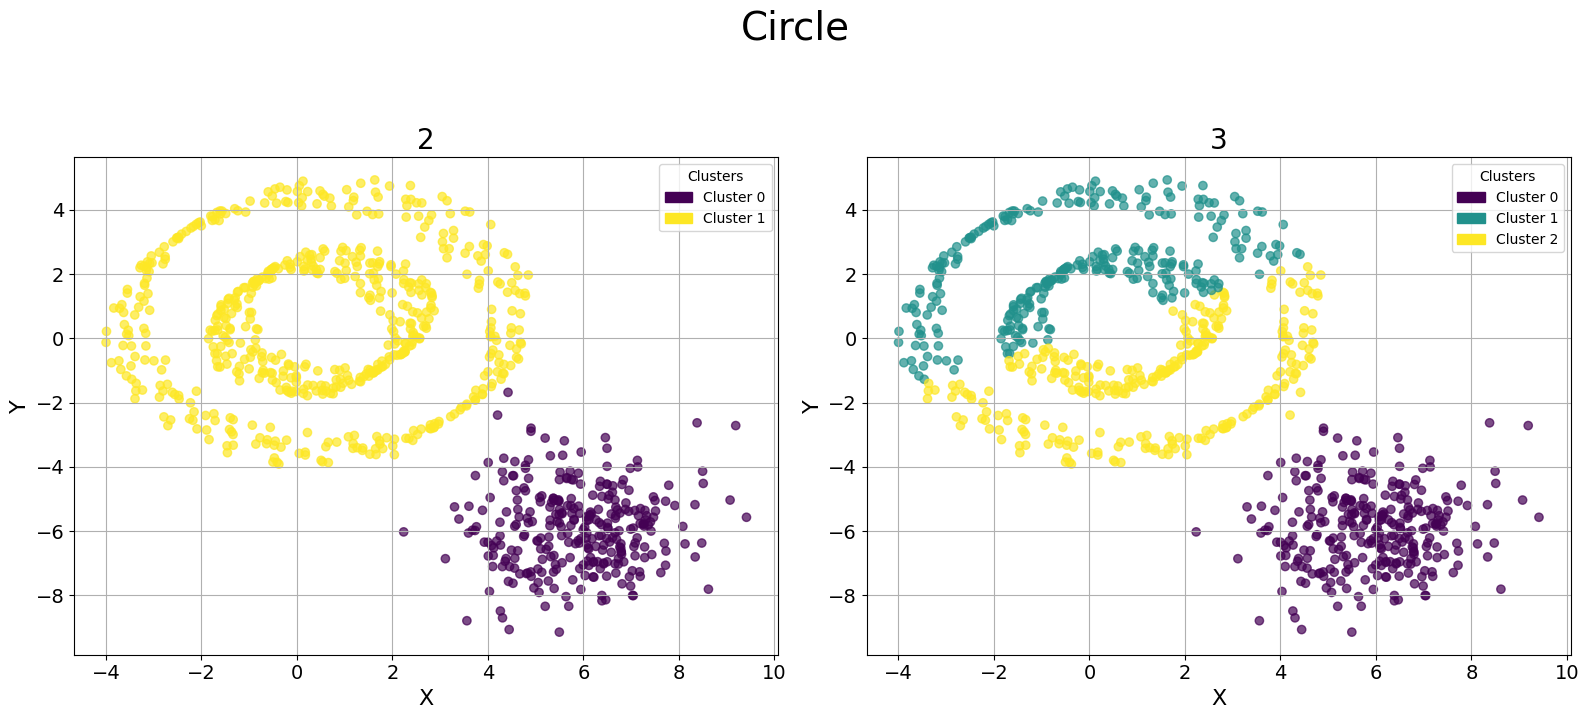

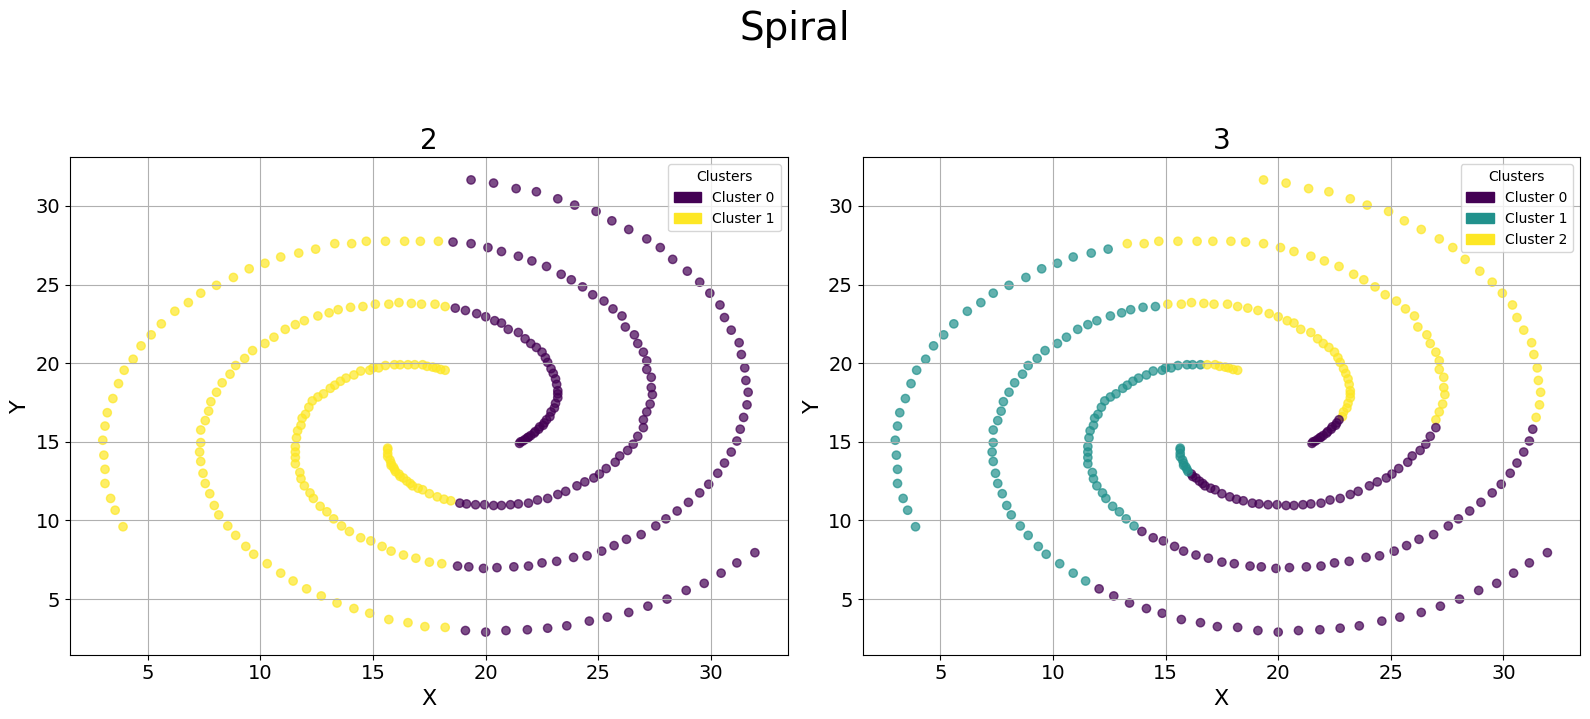

In [ ]:
for name, clustered_data_by_k in clustered_data_k_means.items():
  plot_data(clustered_data_by_k, name)

### **Observations**

#### **Results for the Circle Dataset**

- **For M = 2**, the K-means clustering produced results that are **identical** to those obtained from spectral clustering with *k = 20*.  
  - The only noticeable difference lies in a few **border points**, which were assigned to different clusters.

- **For M = 3**, the k-means clustering produced results that are **not identical** to those from spectral clustering.  
  - The **purple cluster** is classified correctly, while the other two are separated in a clearly **inappropriate** way.

These outcomes are expected from the k-means algorithm:

- For M = 2, the data naturally separates into two regions, and K-means performs well when clusters are **linearly or spherically separable**, as is the case here (yellow and purple regions).

- However, K-means struggles when clusters are **not well-separated in Euclidean space**, particularly when **one cluster surrounds another**.  
  This limitation is evident in the **yellow cluster for M = 2**, and in the **less meaningful partitioning** of points observed for M = 3.

---

#### **Results for the Spiral Dataset**

- **For M = 2**, the K-means algorithm splits the spiral roughly based on proximity.  
  However, this separation does **not reflect** the actual spiral structure, leading to **incorrect boundaries**.

- **For M = 3**, the clustering becomes even more **fragmented**, and the clusters clearly **fail to align** with the underlying spiral arms.

The same conclusion holds as for the **circle** dataset —  
**K-means is ineffective when the clusters are not linearly or spherically separable**.


## **10. Exploring Spectral Clustering on Higher-Dimensional Datasets**


To evaluate spectral clustering in 3D space, we generate a custom dataset consisting of three circles, with a small amount of noise added to each.

1. **Generating 3D circles**:

  We generate three circular rings by using the parametric equations for a circle in 2D:

  $$
  x(t) = x_0 + r \cos(t), \quad y(t) = y_0 + r \sin(t)
  $$

  To move from 2D to 3D, we fix one of the dimensions (e.g., \( z = $z_0$ \)) and generate each circle in a different plane or position by modifying the fixed coordinate.

  A small amount of Gaussian noise is added to the points to better simulate real-world data.

2. **Plotting data in 3D space**
3. **Pipeline performed for previous datasets**

### **Generating data**

In [ ]:
#1
def generate_3d_circles(n=150, noise_std=0.02):

  t = np.linspace(0, 2*np.pi, n, endpoint=False)

  #circle 1 xy, z = 0
  c1 = np.stack([np.cos(t), np.sin(t), np.zeros(n)], axis=1)
  #circle 2 yz, x=-1.2
  c2 = np.stack([-1.2*np.ones(n), np.cos(t), 0.5*np.sin(t)], axis=1)
  #circle 3 yz, x=0.8
  c3 = np.stack([0.8*np.ones(n), np.cos(t), 0.5*np.sin(t)], axis=1)

  X = np.vstack([c1, c2, c3])

  # noise addition
  X += np.random.normal(loc=0.0, scale=noise_std, size=X.shape)

  y = np.array([0]*n + [1]*n + [2]*n)
  return X, y

In [ ]:
#1
X, clusters = generate_3d_circles()

### **Plotting 3D data**

In [ ]:
#2
def plot_3D_data(X, cluster, title = "3D Circles"):

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=cluster, cmap='viridis', alpha=0.7)

    unique_clusters = np.unique(cluster)
    handles = [
        Patch(color=scatter.cmap(scatter.norm(c)), label=f"Cluster {c}")
        for c in unique_clusters
    ]
    ax.legend(handles=handles, title="Clusters", loc='upper left', bbox_to_anchor=(1.05, 1))

    ax.set_title(title, fontsize=20)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.tight_layout()

    # plt.savefig(f"3DCircles.png", format='png')

    plt.show()


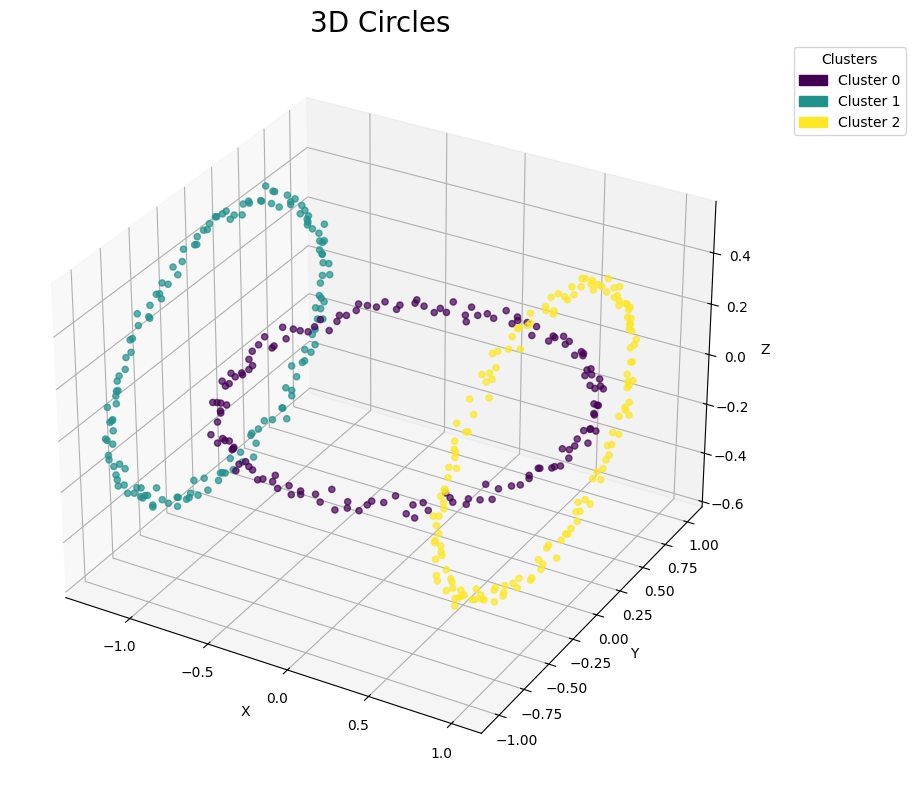

In [ ]:
plot_3D_data(X, clusters)

# **Spectral Clustering Pipeline**

### 1. **Construction of Similarity graph**

In [ ]:
S_3D = {"3D Circles":create_similarity_matrix(X)}

### 2. **Construction of Adjacency Matrices for different values of  k**

---



In [ ]:
k_values = [10, 20, 40]
W_matrices_3D = {}

for name, S in S_3D.items():
  adjacency_by_k = {}
  for k in k_values:
    adjacency_by_k[k] = construct_knn_adjacency_matrix(S, k)

  W_matrices_3D[name] = adjacency_by_k

### 3. **Construction of Degree Matrices**

In [ ]:
k_values = [10, 20, 40]
D_matrices_3D = {}

for name, W_k_dict in W_matrices_3D.items():
  diagonals_by_k = {}
  for k in k_values:
    W = W_k_dict[k] #getting adjacency matrix for defined k
    diagonals_by_k[k] = construct_degree_matrix(W)

  D_matrices_3D[name] = diagonals_by_k

### 4. **Construction of Laplacian matrices**

In [ ]:
k_values = [10, 20, 40]
names = W_matrices_3D.keys()
L_matrices_3D = {}

for name in names:
  laplacians_by_k = {}
  for k in k_values:
    W = W_matrices_3D[name][k]
    D = D_matrices_3D[name][k]

    laplacians_by_k[k] = construct_laplacian_matrix(W, D)

  L_matrices_3D[name] = laplacians_by_k

### 5. **Number of connected components**

In [ ]:
#1.
num_connected_components_3D = {}
names = L_matrices_3D.keys()

for name in names:
  #for each dataset
  num_connected_components_by_k = {}

  print(f"**** {name} DATASET ****")
  for k in k_values:
    L = L_matrices_3D[name][k]
    num_connected_components_by_k[k] = num_of_connected_components(L)
    print(f"For k = {k}, number of connected components is: {num_connected_components_by_k[k]}")


  num_connected_components_3D[name] = num_connected_components_by_k
  print()

**** 3D Circles DATASET ****
For k = 10, number of connected components is: 3
For k = 20, number of connected components is: 2
For k = 40, number of connected components is: 1



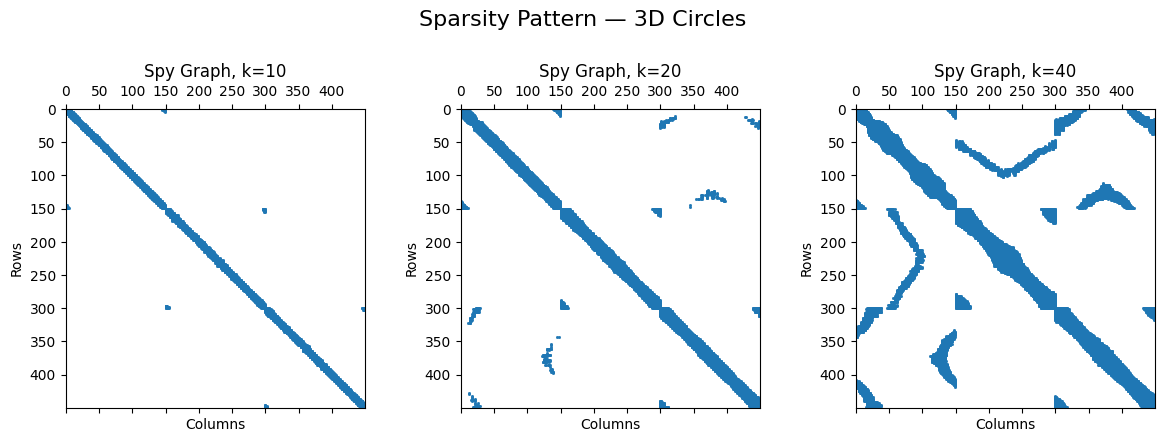

In [ ]:
for name, L_dict in L_matrices_3D.items():
  plot_spy_graphs(L_dict, name)

### **Observations**

- **k = 10:** 3 connected components  
- **k = 20:** 2 connected components  
- **k = 40:** 1 connected component  

We can see that matrices have strongly diagonal structure. Additionally, by increaseing k, more non-zero values appear away from the diagonal, making the graph fully connected for k = 40.


### 6. **Computation of M smallest Eigenvalues**

In [ ]:
eigenpairs_3D = {}
names = L_matrices_3D.keys()

for name in names:
  eigenpairs_by_k = {}

  for k in k_values:
    eigvals, eigvecs = find_M_smallest_eigenvalues(L_matrices_3D[name][k])
    eigenpairs_by_k[k] = (eigvals, eigvecs)

  eigenpairs_3D[name] = eigenpairs_by_k

#### **Plotting M smallest eigenvalues**

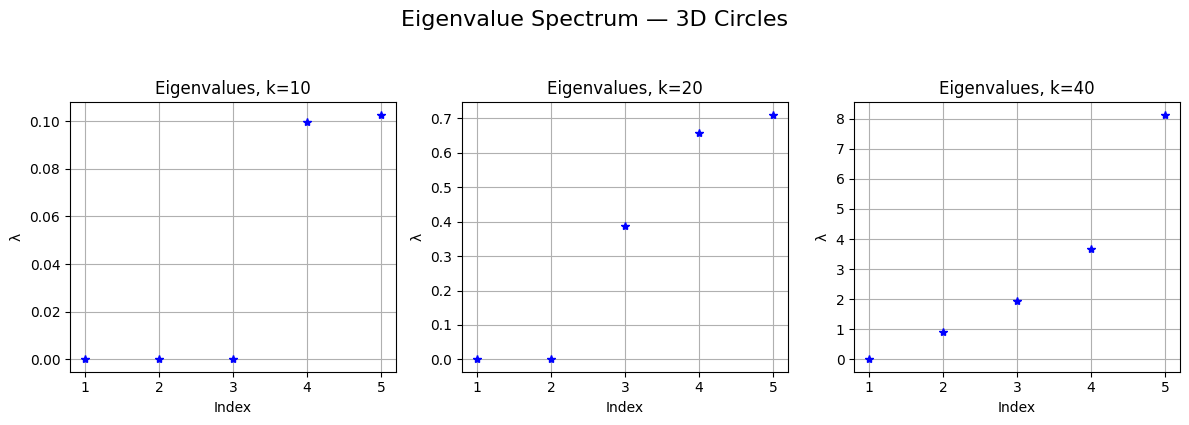

In [ ]:
for name, eigpair in eigenpairs_3D.items():
  plot_eigenvalues(eigpair, name)

### **Observations**

#### Results for the **3D Circles** Dataset

**1. k = 10**  
- A noticeable eigengap is observed between the **3rd** and **4th** eigenvalues, suggesting the presence of **three clusters**, corresponding to the number of zero eigenvalues.  
- **Chosen number of clusters:** M = 3

**2. k = 20**  
- A clear eigengap appears between the **2nd** and **3rd** eigenvalues, suggesting **two main clusters**, corresponding to the number of zero eigenvalues.  
- **Chosen number of clusters:** M = 2

**3. k = 40**  
- A noticeable gap is present between the **1st** and **2nd** eigenvalues, with a significant difference in magnitude.  
- This suggests that *k = 40* may **not be a suitable choice** for clustering this dataset.  
- Nevertheless, for testing purposes, the first two eigenvalues were used.  
- **Chosen number of clusters:** M = 2

We can clearly observe a **difference in the scale of eigenvalues** across different values of *k*.


In [ ]:
number_of_clusters_3D = {
    "3D Circles": {
        10: 3,
        20: 2,
        40: 2
    }
}

### 7. **Construction of U matrices**

In [ ]:
U_matrices_3D = {}
names = L_matrices_3D.keys()
k_values = [10, 20, 40]

for name in names:
  U_matrices_by_k = {}

  for k in k_values:
    num_of_cluster = number_of_clusters_3D[name][k]
    U_matrices_by_k[k] = np.array(eigenpairs_3D[name][k][1][:num_of_cluster]).T

  U_matrices_3D[name] = U_matrices_by_k

### 8. **Clustering Spectral Embedding using K-means**

In [ ]:
cluster_labels_3D = {}
names = U_matrices_3D.keys()
k_values = [10, 20, 40]

for name in names:

  cluster_labels_by_k = {}

  for k in k_values:
    kmeans = KMeans(n_clusters=number_of_clusters_3D[name][k], random_state=random_seed)
    labels = kmeans.fit_predict(U_matrices_3D[name][k])
    cluster_labels_by_k[k] = labels

  cluster_labels_3D[name] = cluster_labels_by_k

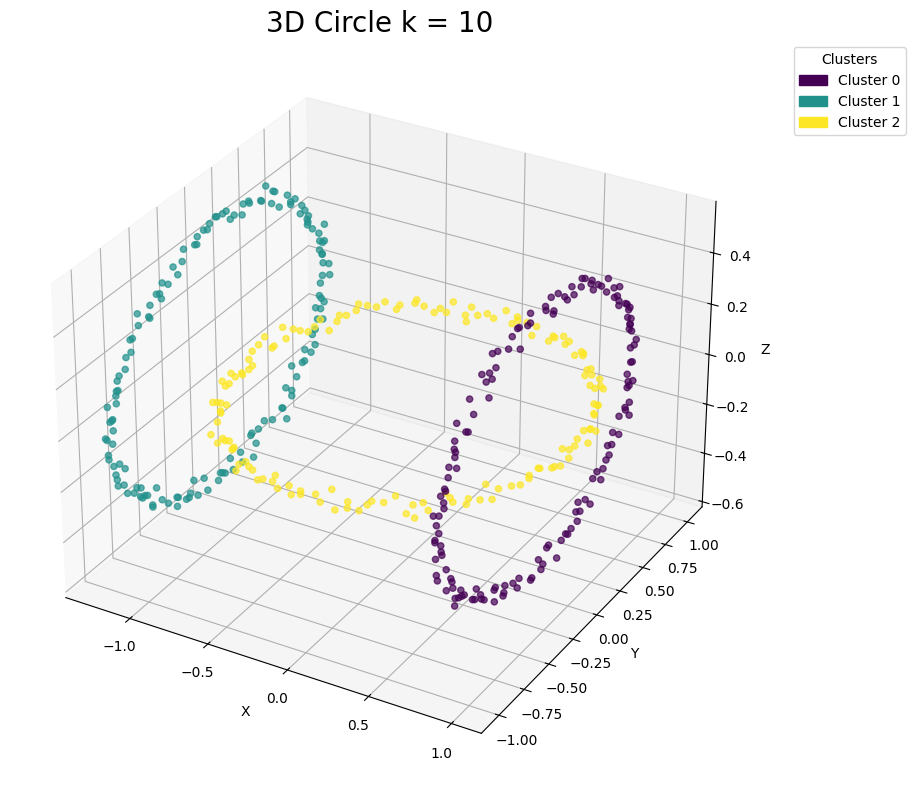

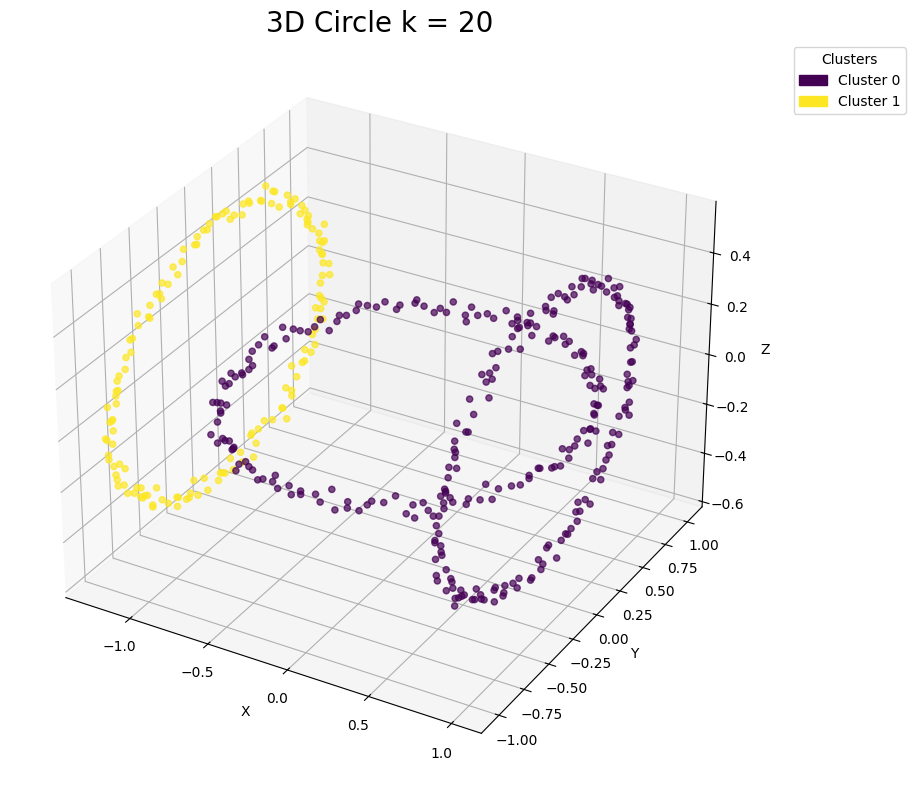

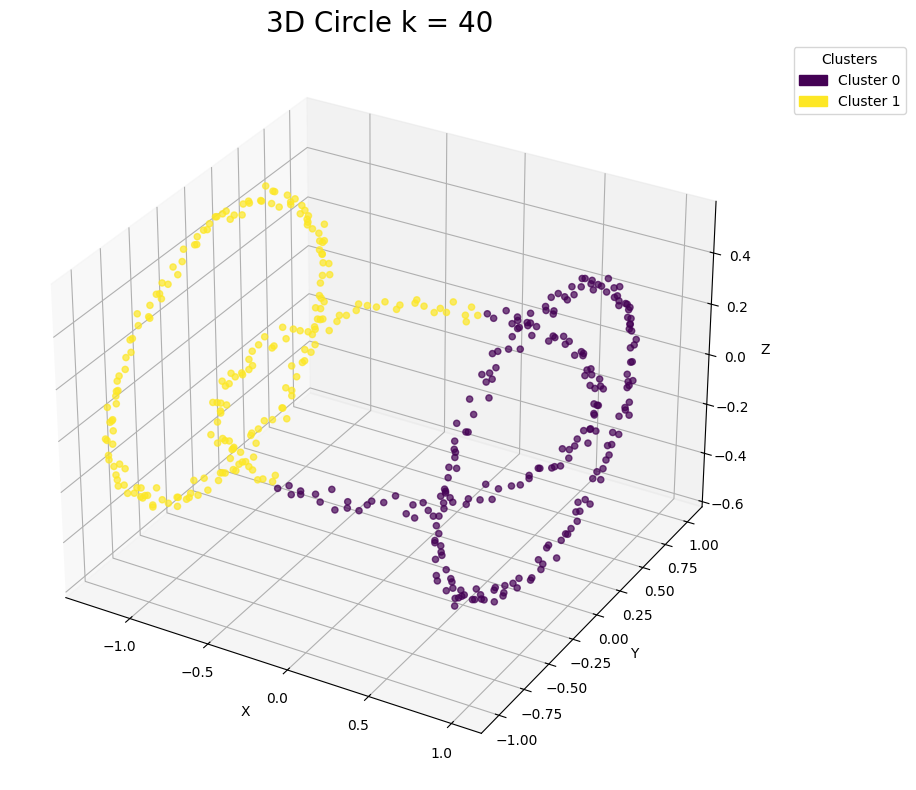

In [ ]:
for k in k_values:
  plot_3D_data(X,cluster_labels_3D["3D Circles"][k], title = f"3D Circle k = {k}")

### **Observations**

**For k = 10**, spectral clustering produced accurate results.

**For k = 20**, the number of clusters was set to 2. In this case, spectral clustering merged the XY ring with the the YZ ring with positive coordinate for X. This outcome is expected, as the 'positive' YZ ring is closer to the XY ring in terms of X-coordinate distance than to the 'negative' (yellow) ring.


### 9. **Comaprison with K-means**

In [ ]:
cluster_labels_k_means_3D = {}
names = U_matrices_3D.keys()
m_values = [2, 3]
for name in names:

  cluster_labels_by_m = {}

  for m in m_values:
    kmeans = KMeans(n_clusters=m, random_state=random_seed)
    labels = kmeans.fit_predict(X)
    cluster_labels_by_m[m] = labels

  cluster_labels_k_means_3D[name] = cluster_labels_by_m

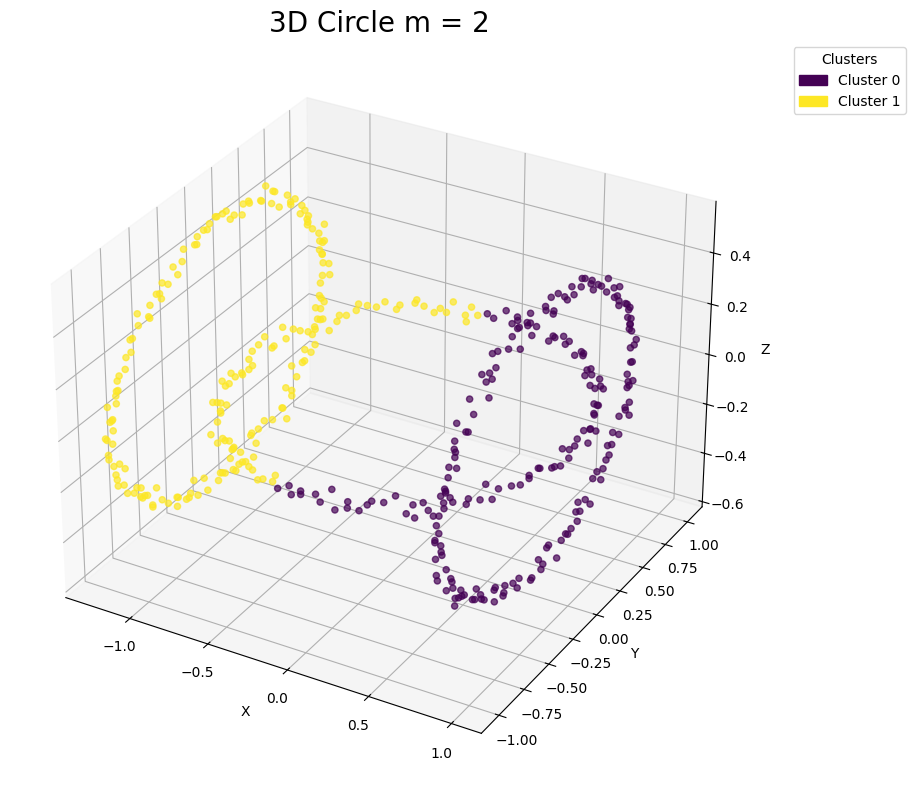

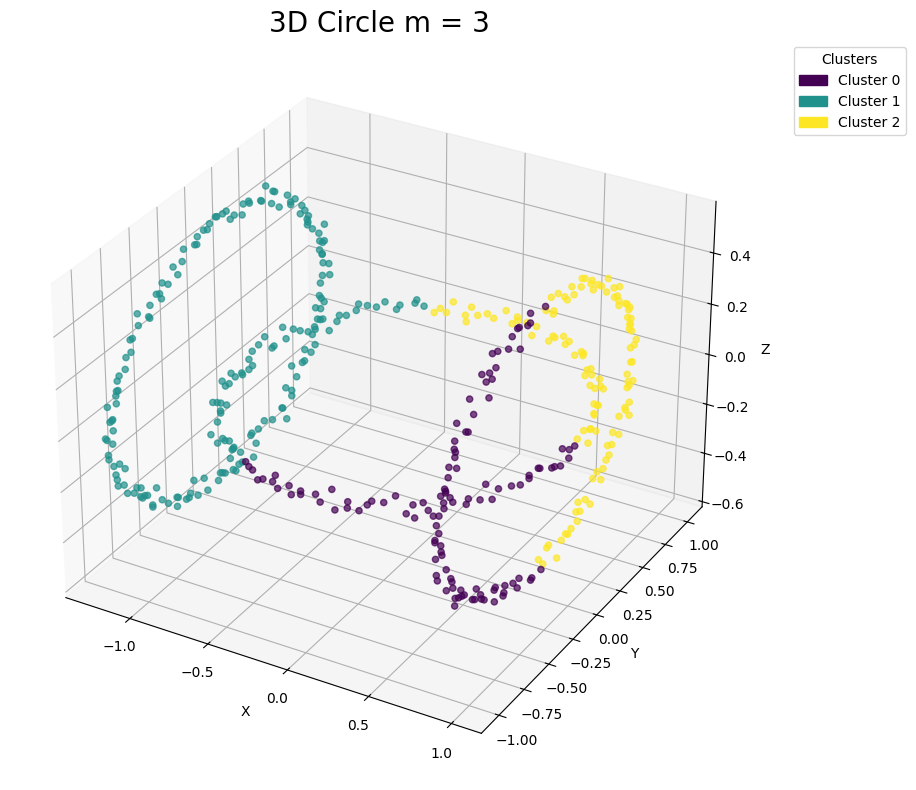

In [ ]:
for m in m_values:
  plot_3D_data(X,cluster_labels_k_means_3D["3D Circles"][m], title = f"3D Circle m = {m}")

## **Observations**

K-means does not recognize the circular structure of the data and performs poorly once again.